In [35]:
from utils import tokenize_with_hex_replacement
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, \
                            roc_curve, f1_score, \
                            precision_recall_curve, roc_curve, \
                            auc, precision_score, recall_score, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt

In [36]:
train = pd.read_parquet('data/train.parquet')
val = pd.read_parquet('data/val.parquet')
test = pd.read_parquet('data/test.parquet')

In [37]:
train.opcode = train.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')
val.opcode = val.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')
test.opcode = test.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')

In [38]:
trfrm = TfidfVectorizer(strip_accents='ascii', analyzer='word',lowercase=True, min_df = 5, ngram_range=(1,4))
X_train_tfidf = trfrm.fit_transform(train.opcode)
X_test_tfidf  = trfrm.transform(test.opcode)
X_val_tfidf  = trfrm.transform(val.opcode)

In [39]:
trfrm.get_feature_names_out()

array(['add', 'add add', 'add add add', ..., 'xor xor xor push28',
       'xor xor xor swap2', 'xor xor xor xor'], dtype=object)

In [40]:
from sklearn.svm import SVC

params = {'kernel': ['linear', 'poly', 'rbf'],
          'C': [0.1, 1, 10, 100, 200]}
skf = StratifiedKFold(n_splits=3)
model = GridSearchCV(SVC(probability=True, random_state=42),
                     params,
                     cv=skf,
                     scoring='roc_auc',
                     return_train_score=True,
                     verbose=0,
                     n_jobs=-1,
                     error_score='raise')

model.fit(X_train_tfidf, train.malicious)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score='raise',
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 200],
                         'kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True, scoring='roc_auc')

In [41]:
model.get_params()

{'cv': StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
 'error_score': 'raise',
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': True,
 'estimator__random_state': 42,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(probability=True, random_state=42),
 'n_jobs': -1,
 'param_grid': {'kernel': ['linear', 'poly', 'rbf'],
  'C': [0.1, 1, 10, 100, 200]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': True,
 'scoring': 'roc_auc',
 'verbose': 0}

In [42]:
import pickle

with open('models_serialized/svm_tfidf.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)

In [11]:
y_pred = model.predict_proba(X_val_tfidf)[:,-1]
y_val = val.malicious

In [12]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = -1  # for infinity

ix = np.argmax(fscore)
print(f'Best Threshold is {thresholds[ix]} with F-Score={fscore[ix]} on validation')
tr = thresholds[ix]

Best Threshold is 0.08379651421746304 with F-Score=0.7500000000000001 on validation


In [13]:
y_pred = model.predict_proba(X_test_tfidf)[:,-1]
y_pred_c = (y_pred > tr)
y_test = test.malicious

------------------------------------TESTING INFO-------------------------------------------------
Roc_Auc on test - 0.9987838477764863
F1 on test - 0.7714285714285715
precision on test - 0.7941176470588235
recall on test - 0.75


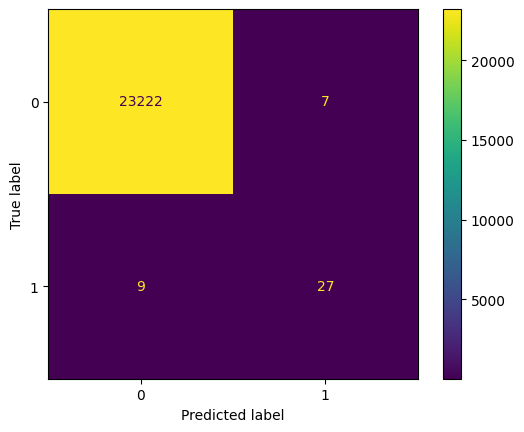

In [14]:
print('------------------------------------TESTING INFO-------------------------------------------------')
print(f'Roc_Auc on test - {roc_auc_score(y_test, y_pred)}')
print(f'F1 on test - {f1_score(y_test, y_pred_c)}')
print(f'precision on test - {precision_score(y_test, y_pred_c)}')
print(f'recall on test - {recall_score(y_test, y_pred_c)}')

cm = confusion_matrix(y_test, y_pred_c, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model.classes_)
disp.plot()
plt.show()

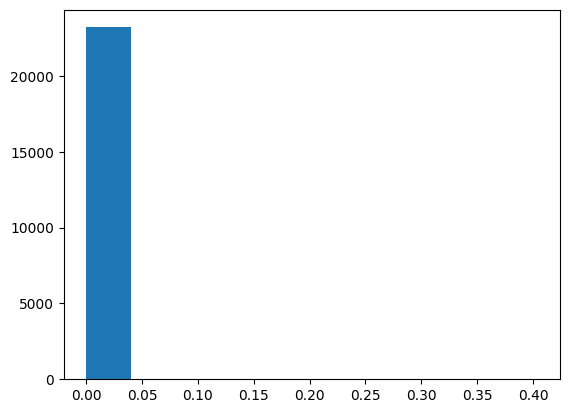

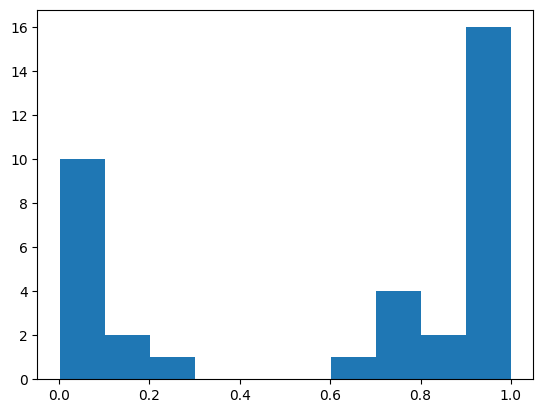

In [15]:
plt.hist(y_pred[y_test==0])
plt.show()
plt.hist(y_pred[y_test==1])
plt.show()

In [43]:
import pickle

with open('models_serialized/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(trfrm, file)